In [22]:
# Install beautifulsoup4
!pip install beatifulsoup4

ERROR: Could not find a version that satisfies the requirement beatifulsoup4 (from versions: none)
ERROR: No matching distribution found for beatifulsoup4


# Web scraping
Ett sätt att samla in data från webbsidor är genom en "skrapning" av hemsidan. I python finns det flera olika biblotek för detta ändemålet men vi kommer att använda `BeautifulSoup`. 

Vi kommer att ta fram data från *Imdb* som är en databas över filmer och tv-serier. Vi kommer att ta fram data om de 250 mest populära filmerna just nu, [imdb top 250](https://www.imdb.com/chart/top/?ref_=nv_mv_250).

In [23]:
# Import libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

#### Ladda hemsida

In [24]:
# Load the webpage content of imdbs' top 250 movies and scrape the data
webpage = requests.get('https://www.imdb.com/chart/top/?ref_=nv_mv_250')

# Create a BeautifulSoup object
soup = BeautifulSoup(webpage.content, 'html.parser')

# print html content
print(soup.prettify())


<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   var IMDbTimer={starttime: new Date().getTime(),pt:'java'};
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
  </script>
  <script>
   (function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);
  </script>
  <title>
   Top 250 Movies - IMDb
  </title>
  <script>
   (function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
  </script>
  <script>
   if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
  </script>
  <link href="https://www.imdb.com/chart/top/" rel="canonical"/>
  <meta content="http://www.imdb.com/chart/top/" property="og:url">
   <script>
  

#### Hitta intressanta taggar
För att kunna skrapa data från en webbsida behöver vi veta vilka taggar som innehåller den information vi vill ha. Detta kan vi göra genom att använda webbläsarens inspektionsverktyg. Genom att högerklicka på en del av sidan och välja "inspektera" så kommer vi åt en meny där vi kan se vilka taggar som innehåller den information vi vill ha.

![data/inspect.png](data/inspect.png "Webbläsarens inspektionsverktyg")

In [25]:

# Manipulate the string to extract the movie titles, rank and raiting
titles = soup.find_all('td', class_='titleColumn') 
t_0 = titles[0]
print(f"Raw title: \n{t_0}\n")  # print raw title

Raw title: 
<td class="titleColumn">
      1.
      <a href="/title/tt0111161/" title="Frank Darabont (dir.), Tim Robbins, Morgan Freeman">Nyckeln till frihet</a>
<span class="secondaryInfo">(1994)</span>
</td>



In [26]:
print(f"Title without tags: \n{t_0.text}\n")  # print title in text format

Title without tags: 

      1.
      Nyckeln till frihet
(1994)




#### Parsa strängar från `BeautifulSoup`

In [36]:
# Parse strings to extract movie title, rank and year
movie_titles = [i.text for i in titles]
movie_titles = [i.replace('\n', '') for i in movie_titles]
movie_titles = [i.strip() for i in movie_titles]
movie_titles = [i.replace('  ', '') for i in movie_titles]
movie_rank = [i.split('.')[0] for i in movie_titles]
movie_year = [i.split('(')[-1].replace(')', '') for i in movie_titles]

movie_titles = [i.split('(')[0] for i in movie_titles]
movie_titles = [i.split('.')[1] for i in movie_titles]

# Create pandas dataframe with the movie titles, rank, and year
movies = pd.DataFrame({
    'movie_titles': movie_titles,
    'movie_rank': movie_rank,
    'movie_year': movie_year
    },
    index=movie_rank
)

movies

,movie_titles,movie_rank,movie_year
1,Nyckeln till frihet,1,1994
2,Gudfadern,2,1972
3,The Dark Knight,3,2008
4,Gudfadern del II,4,1974
5,12 edsvurna män,5,1957
...,...,...,...
246,Vägvisaren,246,1975
247,Aladdin,247,1992
248,Niceville,248,2011
249,Järnjätten,249,1999


### Lägg till raiting

In [40]:

# Extract the movie ratings
raitings = soup.find_all('td', class_='ratingColumn imdbRating')
movie_ratings = [i.get_text() for i in raitings]
movie_ratings = [i.replace('\n', '') for i in movie_ratings]
movie_ratings = [i.strip() for i in movie_ratings]

# Add the movie ratings to the dataframe
movies['movie_ratings'] = movie_ratings

movies

movies.iloc[142:145,:]

,movie_titles,movie_rank,movie_year,movie_ratings
143,Spider-Man: No Way Home,143,2021,8.2
144,Yojimbo,144,1961,8.1
145,Shutter Island,145,2010,8.1


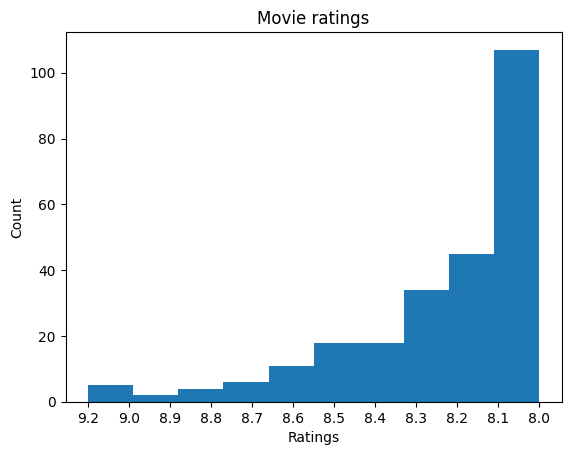

In [41]:
# Plot movie ratings in histogram
plt.hist(movies['movie_ratings'], bins=10)
plt.title('Movie ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


### Vilken datatype har vår data?
När vi använt en scraper för att hämta data från en webbsida så får vi oftast en lista med strängar. Detta är inte så praktiskt att arbeta med. Vi vill helst jobba med numeriska värden i `pandas`-dataframes. Vi kan använda `pandas`-funktionen `to_numeric` för att konvertera strängar till numeriska värden.

In [47]:
# Get types of columns
movies.dtypes

movies['movie_ratings'] = movies['movie_ratings'].astype(float)
movies.dtypes

movie_titles      object
movie_rank         int64
movie_year         int64
movie_ratings    float64
dtype: object

In [49]:
# Convert the dataframe to numeric values

# movies.iloc[142:145,:]

movies[['movie_ratings', 'movie_rank', 'movie_year']] = movies[['movie_ratings', 'movie_rank', 'movie_year']].apply(pd.to_numeric)
# movies['movie_ratings'] = pd.to_numeric(movies['movie_ratings'])
# movies['movie_year'] = pd.to_numeric(movies['movie_year'])
# movies['movie_rank'] = pd.to_numeric(movies['movie_rank'])

movies.dtypes


movie_titles      object
movie_rank         int64
movie_year         int64
movie_ratings    float64
dtype: object

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U4'), dtype('float64')) -> None

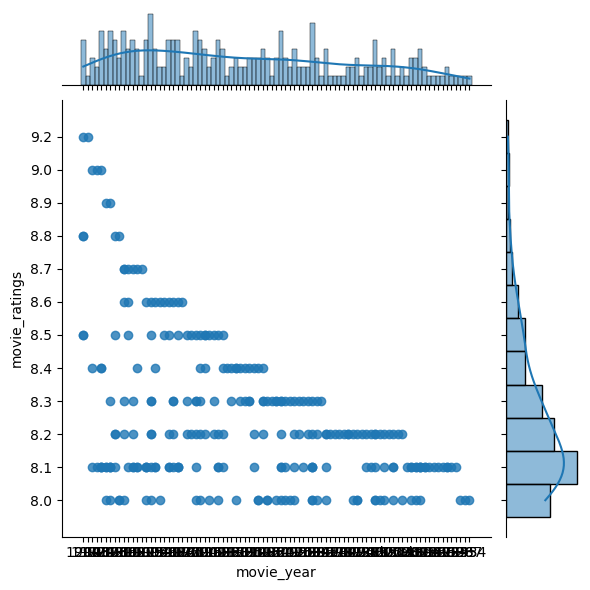

In [30]:
# Joint plot of movie raiting and year
import seaborn as sns
sns.jointplot(x=movies['movie_year'], y=movies['movie_ratings'], kind='reg')
plt.show()
